In [238]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from numpy.fft import *

Loading the development and evaluation datasets

In [239]:
data = pd.read_csv('development.tsv', sep='\t')
eval_data = pd.read_csv('evaluation.tsv', sep='\t')

In [240]:
iq_data = data[data['city'] == 'iq'].copy()
iq_data.drop(columns=['city'], inplace=True)

eval_data.drop(columns=['city'], inplace=True)

In [241]:
iq_data['week_start_date'] = iq_data['week_start_date'].apply(pd.to_datetime)

eval_data['week_start_date'] = eval_data['week_start_date'].apply(pd.to_datetime)

Split of the data in training and test for avoiding data leakage

In [242]:
from sklearn.model_selection import train_test_split

y = iq_data['total_cases']
X = iq_data.drop(columns=['total_cases'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [243]:
X_train.shape, X_test.shape

((273, 19), (117, 19))

Verifying the presence of NaN values

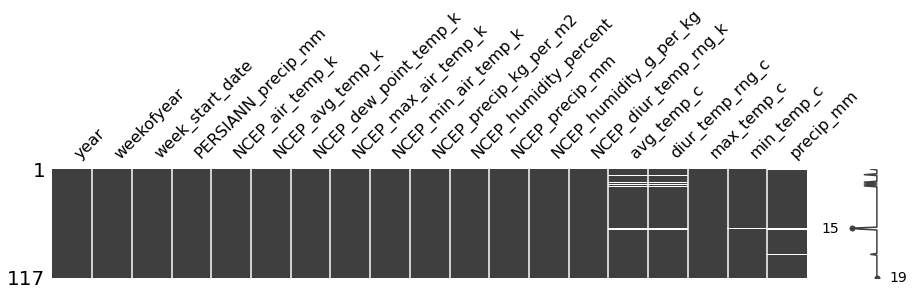

In [244]:
import missingno as msno

msno.matrix(X_test, figsize=(15,2))
plt.show()

Replacing the NaN values by using the KNNImputer Algorithm

In [245]:
from sklearn.impute import KNNImputer

imputer= KNNImputer(n_neighbors=2)

train_dates = X_train['week_start_date'].tolist()
test_dates = X_test['week_start_date'].tolist()
X_train = X_train.drop(columns=['week_start_date'])
X_test =  X_test.drop(columns=['week_start_date'])

evaluation_dates = eval_data['week_start_date'].tolist()
eval_data = eval_data.drop(columns=['week_start_date'])

cols = X_train.columns

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=cols)
X_test = pd.DataFrame(imputer.transform(X_test), columns=cols)
eval_data = pd.DataFrame(imputer.transform(eval_data), columns=cols)

X_train['week_start_date'] = train_dates
X_test['week_start_date'] = test_dates
eval_data['week_start_date'] = evaluation_dates

Removing 'year' from the features to obtain a time independent model, week_start_date is still useful for aggragating the data

In [246]:
X_train = X_train.drop(columns=['year'])
X_test = X_test.drop(columns=['year'])
eval_data = eval_data.drop(columns=['year'])

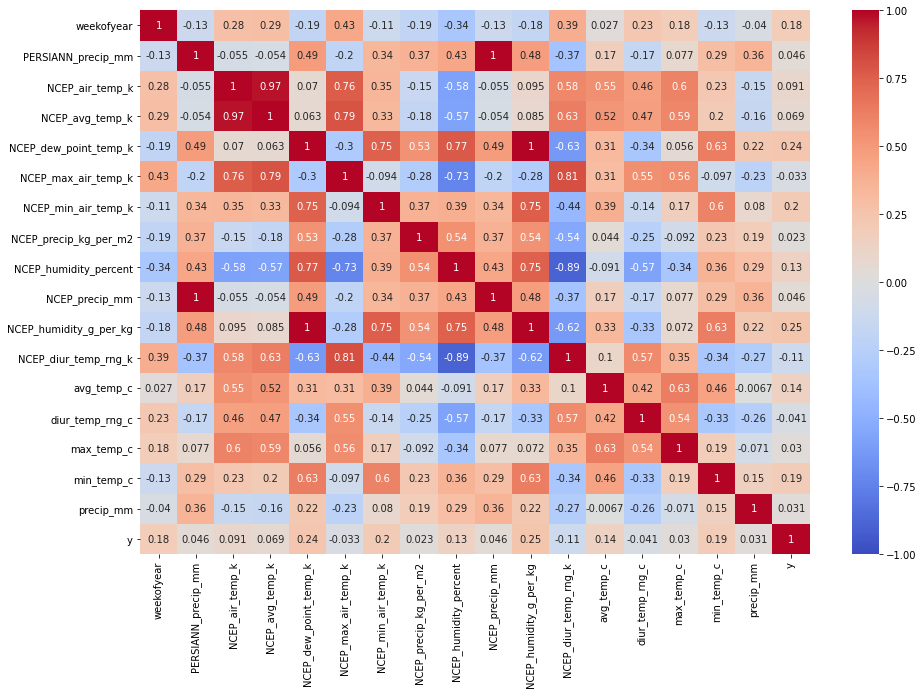

In [247]:
a = X_train.copy()
a['y'] = y_train.tolist()

fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(a.corr(), annot=True, vmin=-1, vmax=1, center= 0, cmap='coolwarm')

Removing redundant features based on the cross correlation analysis.

In [248]:
X_train = X_train.drop(columns=['PERSIANN_precip_mm', 'NCEP_dew_point_temp_k', 'NCEP_avg_temp_k'])
X_test = X_test.drop(columns=['PERSIANN_precip_mm', 'NCEP_dew_point_temp_k','NCEP_avg_temp_k'])
eval_data = eval_data.drop(columns=['PERSIANN_precip_mm', 'NCEP_dew_point_temp_k','NCEP_avg_temp_k'])

In [249]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

scaler = StandardScaler()
used_cols = ['mean_temp',   'humidity', 'min_temp', 'precip_mm', 'max_temp', 'diur_temp', 'weekofyear']
preprocessor = ColumnTransformer(transformers=[('num', scaler, used_cols)])
pre = Pipeline(steps=[('preprocessor', preprocessor)])

D_file_test = pd.DataFrame()
D_file_eval = pd.DataFrame()

X_train_o = X_train.copy()
X_test_o = X_test.copy()
eval_o = eval_data.copy()

In [250]:
X_train_week = X_train['weekofyear'].tolist()
X_test_week = X_test['weekofyear'].tolist()
eval_data_week = eval_data['weekofyear'].tolist()

In [251]:
from sklearn.linear_model import LinearRegression, BayesianRidge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

model11 = Lasso(alpha=0.5, tol=1e-4, random_state=50)
model12 = BayesianRidge(n_iter=300, tol=1e-2)
model13 = LinearRegression()

model21 = RandomForestRegressor(criterion='mae', random_state=50)
model22 = DecisionTreeRegressor(criterion='mae', random_state=50)
model23 = GradientBoostingRegressor(criterion='mae', random_state=50)

In [252]:
for i in [7,14,21,28,35,42,49,56,63,70,77,84]:
    
    # aggregating based on i days

    idx_X_train = X_train_o.copy().reset_index().sort_values(by='week_start_date')['index']
    X_train_agg = X_train_o.copy().sort_values(by='week_start_date').set_index('week_start_date').rolling(window=f'{i}D').mean().reset_index().drop(columns=['week_start_date'])
    X_train_agg['index'] = idx_X_train
    X_train_agg = X_train_agg.sort_values(by='index').drop(columns=['index'])

    idx_X_test = X_test_o.copy().reset_index().sort_values(by='week_start_date')['index']
    X_test_agg = X_test_o.copy().sort_values(by='week_start_date').set_index('week_start_date').rolling(window=f'{i}D').mean().reset_index().drop(columns=['week_start_date'])
    X_test_agg['index'] = idx_X_train
    X_test_agg = X_test_agg.sort_values(by='index').drop(columns=['index'])

    idx_eval = eval_o.copy().reset_index().sort_values(by='week_start_date')['index']
    eval_agg = eval_o.copy().sort_values(by='week_start_date').set_index('week_start_date').rolling(window=f'{i}D').mean().reset_index().drop(columns=['week_start_date'])
    eval_agg['index'] = idx_eval
    eval_agg = eval_agg.sort_values(by='index').drop(columns=['index'])

    # merging similar features

    X_train['mean_temp'] = 0.5*(X_train_agg['NCEP_air_temp_k'] + X_train_agg['avg_temp_c'] + 273)
    X_train['min_temp'] = 0.5*(X_train_agg['NCEP_min_air_temp_k'] + X_train_agg['min_temp_c'] + 273)
    X_train['max_temp'] = 0.5*(X_train_agg['NCEP_max_air_temp_k'] + X_train_agg['max_temp_c'] + 273)
    X_train['diur_temp'] = 0.5*(X_train_agg['NCEP_diur_temp_rng_k'] + X_train_agg['diur_temp_rng_c'])
    X_train['precip_mm'] = 1/3*(X_train_agg['NCEP_precip_mm'] + X_train_agg['precip_mm'] + X_train_agg['NCEP_precip_kg_per_m2'])
    X_train['humidity'] = X_train_agg['NCEP_humidity_percent']
    X_train['weekofyear'] = X_train_week

    X_test['mean_temp'] = 0.5*(X_test_agg['NCEP_air_temp_k'] + X_test_agg['avg_temp_c'] + 273)
    X_test['min_temp'] = 0.5*(X_test_agg['NCEP_min_air_temp_k'] + X_test_agg['min_temp_c'] + 273)
    X_test['max_temp'] = 0.5*(X_test_agg['NCEP_max_air_temp_k'] + X_test_agg['max_temp_c'] + 273)
    X_test['diur_temp'] = 0.5*(X_test_agg['NCEP_diur_temp_rng_k'] + X_test_agg['diur_temp_rng_c'])
    X_test['precip_mm'] = 1/3*(X_test_agg['NCEP_precip_mm'] + X_test_agg['precip_mm'] + X_test_agg['NCEP_precip_kg_per_m2'])
    X_test['humidity'] = (X_test_agg['NCEP_humidity_percent'])
    X_test['weekofyear'] = X_test_week

    eval_data['mean_temp'] = 0.5*(eval_agg['NCEP_air_temp_k'] + eval_agg['avg_temp_c'] + 273)
    eval_data['min_temp'] = 0.5*(eval_agg['NCEP_min_air_temp_k'] + eval_agg['min_temp_c'] + 273)
    eval_data['max_temp'] = 0.5*(eval_agg['NCEP_max_air_temp_k'] + eval_agg['max_temp_c'] + 273)
    eval_data['diur_temp'] = 0.5*(eval_agg['NCEP_diur_temp_rng_k'] + eval_agg['diur_temp_rng_c'])
    eval_data['precip_mm'] = 1/3*(eval_agg['NCEP_precip_mm'] + eval_agg['precip_mm'] + eval_agg['NCEP_precip_kg_per_m2'])
    eval_data['humidity'] = (eval_agg['NCEP_humidity_percent'])
    eval_data['weekofyear'] = eval_data_week

    cols_drop = [x for x in X_train.columns if x not in used_cols]
    X_train = X_train.drop(columns=cols_drop)
    X_test = X_test.drop(columns=cols_drop)
    eval_data = eval_data.drop(columns=cols_drop)

    # standarizing the obtained columns

    X_train_new = pd.DataFrame(pre.fit_transform(X_train), columns=used_cols)
    X_test_new = pd.DataFrame(pre.transform(X_test), columns=used_cols)
    eval_data_new = pd.DataFrame(pre.transform(eval_data), columns=used_cols)

    # extracting the new features

    model11.fit(X_train_new, y_train)
    D_file_test[f'agg_{i}'] = model11.predict(X_test_new)  
    D_file_eval[f'agg_{i}'] = model11.predict(eval_data_new)


In [253]:
D_file_test['weekofyear'] = X_test_week
D_file_eval['weekofyear'] = eval_data_week

In [254]:
y_test_o = y_test

In [255]:
X_train, X_test, y_train, y_test = train_test_split(D_file_test.reset_index(drop=True), y_test_o.reset_index(drop=True), test_size=0.3, shuffle=False)

In [256]:
used_cols = ['agg_7','agg_14','agg_21','agg_28','agg_35','agg_42','agg_49','agg_56','agg_63','agg_70','agg_77','agg_84','weekofyear']
# used_cols = ['agg_7','agg_84','weekofyear']

preprocessor = ColumnTransformer(transformers=[('num', scaler, used_cols)])
pre = Pipeline(steps=[('preprocessor', preprocessor)])


X_train = pd.DataFrame(pre.fit_transform(X_train), columns=used_cols)
X_test = pd.DataFrame(pre.transform(X_test), columns=used_cols)
D_file_eval = pd.DataFrame(pre.transform(D_file_eval), columns=used_cols)


In [257]:
model21.fit(X_train, y_train)
model22.fit(X_train, y_train)
model23.fit(X_train, y_train)

print('model21: ',mean_absolute_error(model21.predict(X_test), y_test))
print('model22: ',mean_absolute_error(model22.predict(X_test), y_test))
print('model23: ',mean_absolute_error(model23.predict(X_test), y_test))

model21:  4.260972222222223
model22:  4.666666666666667
model23:  4.668521449914449


In [258]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(model21)
sel.fit(X_train, y_train)

(X_train.columns[sel.get_support()]).tolist()

['agg_7', 'agg_84', 'weekofyear']

the most important features according to SelectFromModel() are: 'agg_7', 'agg_84', 'weekofyear'

In [259]:
X_train, X_test, y_train, y_test = train_test_split(D_file_test.reset_index(drop=True), y_test_o.reset_index(drop=True), test_size=0.3, shuffle=False)

In [260]:
used_cols = ['agg_7','agg_84','weekofyear']

preprocessor = ColumnTransformer(transformers=[('num', scaler, used_cols)])
pre = Pipeline(steps=[('preprocessor', preprocessor)])


X_train = pd.DataFrame(pre.fit_transform(X_train), columns=used_cols)
X_test = pd.DataFrame(pre.transform(X_test), columns=used_cols)
D_file_eval = pd.DataFrame(pre.transform(D_file_eval), columns=used_cols)

In [261]:
model21.fit(X_train, y_train)
model22.fit(X_train, y_train)
model23.fit(X_train, y_train)

print('model21: ',mean_absolute_error(model21.predict(X_test), y_test))
print('model22: ',mean_absolute_error(model22.predict(X_test), y_test))
print('model23: ',mean_absolute_error(model23.predict(X_test), y_test))

model21:  4.347222222222222
model22:  4.944444444444445
model23:  4.645198159492081


Computing hyperparameter tunning

In [262]:
from sklearn.model_selection import GridSearchCV

search_space_21 = {
    "n_estimators": [100, 150, 200],
    "min_samples_split": [2, 3, 4],
    "criterion": ['mae'],
    "max_features": ['auto','sqrt', 'log2'],
    "random_state": [50]
}

search_space_22 = {
    "min_samples_split": [2, 3, 4],
    "max_features": ['auto', 'log2', 'sqrt'],
    "splitter": ['best','random'],
    "criterion": ['mae'],
    "random_state": [50]
}

search_space_23 = {
    "loss": ['ls', 'huber', 'quantile'],
    "n_estimators": [100, 150, 200],
    "criterion": ['mae'],
    "max_features": ['auto', 'log2', 'sqrt'],
    "min_samples_split": [2, 3, 4],
    "random_state": [50]
}

In [263]:
grid_21 = GridSearchCV(estimator=RandomForestRegressor(), 
                    param_grid=search_space_21,
                    cv=None,
                    scoring='neg_mean_absolute_error',
                    return_train_score=True,
                    n_jobs=-1,  
                    )

grid_22 = GridSearchCV(estimator=DecisionTreeRegressor(), 
                    param_grid=search_space_22,
                    cv=None,
                    scoring='neg_mean_absolute_error',
                    return_train_score=True,
                    n_jobs=-1,  
                    ) 

grid_23 = GridSearchCV(estimator=GradientBoostingRegressor(), 
                    param_grid=search_space_23,
                    cv=None,
                    scoring='neg_mean_absolute_error',
                    return_train_score=True,
                    n_jobs=-1,  
                    ) 

In [264]:
best_21 = grid_21.fit(X_train,y_train)
best_22 = grid_22.fit(X_train,y_train)
best_23 = grid_23.fit(X_train,y_train)

In [265]:
print('best_21: ', best_21.best_params_)
print('best_22: ', best_22.best_params_)
print('best_23: ', best_23.best_params_)

best_21:  {'criterion': 'mae', 'max_features': 'auto', 'min_samples_split': 4, 'n_estimators': 100, 'random_state': 50}
best_22:  {'criterion': 'mae', 'max_features': 'log2', 'min_samples_split': 4, 'random_state': 50, 'splitter': 'random'}
best_23:  {'criterion': 'mae', 'loss': 'ls', 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 50}


In [266]:
model21 = RandomForestRegressor(criterion='mae', min_samples_split=4, random_state=50)
model22 = DecisionTreeRegressor(criterion='mae', max_features='log2', min_samples_split=4, splitter='random', random_state=50)
model23 = GradientBoostingRegressor(criterion='mae', loss='ls', random_state=50)

In [267]:
model21.fit(X_train, y_train)
model22.fit(X_train, y_train)
model23.fit(X_train, y_train)

print('model21: ',mean_absolute_error(model21.predict(X_test), y_test))
print('model22: ',mean_absolute_error(model22.predict(X_test), y_test))
print('model23: ',mean_absolute_error(model23.predict(X_test), y_test))

model21:  4.389444444444444
model22:  5.111111111111111
model23:  4.645198159492081


predicting the dengue cases for the evaluation file

In [268]:
pred_test = model21.predict(X_test)
pred_eval = model21.predict(D_file_eval)

In [269]:
predictions = pd.DataFrame(model21.predict(D_file_eval).tolist(), columns=['Predicted'])

predictions.to_csv('myPredictions2.csv',index_label='Id')